In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.special import sph_harm
from scipy.integrate import quad, dblquad

import numpy as np
import trimesh as tri
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sys
import os

sys.path.insert(0,"../")
import pyssht
sphere = tri.creation.uv_sphere(count=[16, 16])

In [2]:
class Brownian():
    """
    A Brownian motion class constructor
    """
    def __init__(self,x0=0):
        """
        Init class
        """
        assert (type(x0)==float or type(x0)==int or x0 is None), "Expect a float or None for the initial value"
        
        self.x0 = float(x0)
    
    def gen_random_walk(self,n_step=100):
        """
        Generate motion by random walk
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        # Warning about the small number of steps
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution with probability 1/2
            yi = np.random.choice([1,-1])
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w
    
    def gen_normal(self, step_size, n_step=100):
        """
        Generate motion by drawing from the Normal distribution
        
        Arguments:
            n_step: Number of steps
            
        Returns:
            A NumPy array with `n_steps` points
        """
        if n_step < 30:
            print("WARNING! The number of steps is small. It may not generate a good stochastic process sequence!")
        
        w = np.ones(n_step)*self.x0
        
        for i in range(1,n_step):
            # Sampling from the Normal distribution
            yi = np.random.normal(0, step_size)
            # Weiner process
            w[i] = w[i-1]+(yi/np.sqrt(n_step))
        
        return w

In [3]:
b = Brownian() 
b.gen_normal(1/50, n_step=50)

array([0.        , 0.00151904, 0.0016306 , 0.0027203 , 0.00156253,
       0.00439742, 0.01289148, 0.01692337, 0.01706335, 0.01772116,
       0.01265235, 0.01560857, 0.01463266, 0.01776071, 0.01350864,
       0.01021046, 0.01336455, 0.01427763, 0.01429924, 0.01341854,
       0.01249984, 0.00531986, 0.00833233, 0.0115457 , 0.01131545,
       0.01038271, 0.0115067 , 0.01298616, 0.01813217, 0.01002103,
       0.01692294, 0.02117779, 0.0199788 , 0.02300216, 0.01965891,
       0.01608242, 0.01506065, 0.01189568, 0.01253313, 0.01200896,
       0.00690547, 0.00539744, 0.004295  , 0.00886393, 0.00975034,
       0.01419543, 0.00970552, 0.00806257, 0.00866695, 0.01710251])

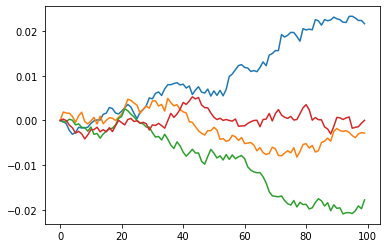

In [4]:
b = Brownian(0) 
for i in range(4):
    plt.plot(b.gen_normal(1/100))
plt.show()

## Spherical decomposition and reconstruction tools

In [5]:
import numpy as np
from scipy.special import sph_harm
import scipy.integrate as integrate

class SphHarmBasis():
    def __init__(self, n_coeffs=16):
        self._n_coeffs = n_coeffs
        self.basis = self.sph_harm_basis()
    
    def get_sph_harm_function(self, l, m):
        """Compute real spherical harmonic basis function"""
        def basis_function(theta, phi):
            Y = sph_harm(abs(m), l, phi, theta)
            
            if m < 0:
                Y = np.sqrt(2) * (-1)**m * Y.imag
            elif m > 0:
                Y = np.sqrt(2) * (-1)**m * Y.real
                
            return Y.real
        
        return basis_function

    def sph_harm_basis(self):
        """Get a specified number of basis functions"""
        basis_functions = []

        dimension = 0
        l, m = 0, 0

        while dimension < self._n_coeffs:
            while m <= l:
                basis_functions.append(self.get_sph_harm_function(l, m))
                m += 1
                dimension += 1
            
            l += 1
            m = -l  
        
        return basis_functions

    def sph_harm_coeff(self, Y, f):
        """Compute spherical harmonic coefficients"""
        def integrand(phi, theta):
            return f(theta, phi) * Y(theta, phi) * np.sin(theta)
        options={'limit':50}
        res = integrate.nquad(integrand, [[0., 2*np.pi], [0., np.pi]], opts=[options,options] )[0]
        return res

    def sph_harm_transform(self, f, basis=None):
        """Get spherical harmonic coefficients for a function in a basis"""
        if basis is None:
            basis = self.basis
        
        coeffs = []

        for Y in basis:
            coeffs.append(self.sph_harm_coeff(Y, f))

        return coeffs

    def sph_harm_reconstruct(self, coeffs, basis=None):
        """Reconstruct a function from basis and corresponding coefficients"""
        if basis is None:
            basis = self.basis
        
        return lambda theta, phi : np.dot(coeffs, [f(theta, phi) for f in basis])
    
    def sph_harm_reconstruct_random(self, coeffs, Q, t, basis=None):
        """Reconstruct a function from basis and corresponding coefficients"""
        if basis is None:
            basis = self.basis
            
        #b = Brownian()
        #b.gen_normal(1/50, n_step=50)
        #coeffs_stoch = coeffs
        
        sigma = np.sqrt(t)
        #return lambda theta, phi : np.dot(coeffs + , [f(theta, phi) for f in basis])
        return lambda theta, phi : np.dot(coeffs + Q.dot(np.random.normal(0, sigma, len(coeffs))), [f(theta, phi) for f in basis])

In [6]:
def my_sphere_function(theta, phi):
    return np.sin(theta+phi)

my_basis = SphHarmBasis(n_coeffs=50)

# encode your function in the desired basis and record the coefficients
my_coeffs = my_basis.sph_harm_transform(my_sphere_function)

# reconstruct your function at a point
point = (np.pi/8, np.pi/8)
my_basis.sph_harm_reconstruct(my_coeffs)(*point), my_sphere_function(*point)

(0.7247666245534461, 0.7071067811865475)

### Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.09154428076249482


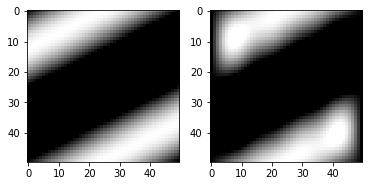

In [7]:
my_reconstr_function = my_basis.sph_harm_reconstruct(my_coeffs)

pts_phi = np.linspace(0, 2*np.pi)
pts_theta = np.linspace(0, np.pi)
pts_2d = np.reshape(np.stack(np.meshgrid(pts_theta,pts_phi), axis=-1), (-1, 2))

actual = []
approx = []

pts_total = 0

for n, pt in enumerate(pts_2d):
    f_actual = my_sphere_function(*pt)
    f_approx = my_reconstr_function(*pt)
    
    actual.append(f_actual)
    approx.append(f_approx)

    pts_total += abs(f_approx - f_actual)
    
print(pts_total / len(pts_2d))

plt.subplot(121)
plt.imshow(np.reshape(np.repeat(actual, 3), (50, 50, 3)))

plt.subplot(122)
plt.imshow(np.reshape(np.repeat(approx, 3), (50, 50, 3)))
plt.show()

### For shapes (test with the 2-sphere)

In [8]:
def my_sphere_function_r(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

In [9]:
sphere = tri.creation.uv_sphere(count=[24, 24])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

In [11]:
f_actual_r = my_sphere_function_r(theta,phi)
f_actual_theta = my_sphere_function_theta(theta,phi)
f_actual_phi = my_sphere_function_phi(theta,phi)

In [12]:
f_actual_r

array([1., 1., 1., ..., 1., 1., 1.])

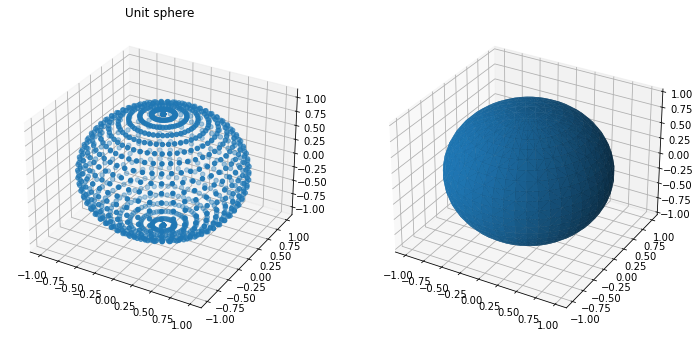

In [13]:
(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(f_actual_r, f_actual_theta, f_actual_phi)
mesh = tri.convex.convex_hull(np.array([x_coord, y_coord, z_coord]).T)

fig = plt.figure(figsize=(12,12))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])

plt.show()

In [14]:
my_basis = SphHarmBasis(n_coeffs=50)

my_coeffs_r = my_basis.sph_harm_transform(my_sphere_function_r)
my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)

print(my_coeffs_r, my_coeffs_theta, my_coeffs_phi)

my_reconstr_function_r = my_basis.sph_harm_reconstruct(my_coeffs_r)
my_reconstr_function_theta = my_basis.sph_harm_reconstruct(my_coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(my_coeffs_phi)

[3.5449077018110313, 1.7290667856440976e-16, 1.8744955160717832e-16, 2.1294613108520634e-16, -6.134087710160868e-17, -1.3978403631409183e-17, 4.3598356225107897e-16, -3.484705388089876e-17, -2.8770782241431806e-16, 5.585369046499437e-17, -8.187887435880087e-18, 2.583552846274953e-17, 2.9117478640282497e-16, 6.137837077629482e-17, 9.908087329322988e-18, -8.766456384482416e-17, -5.606356818101614e-16, 1.2368875714174103e-18, -2.4828408298337656e-17, -5.1017225837249966e-18, 5.667786309264027e-16, -7.08764281130578e-18, -6.857952788442275e-17, 7.355954178587864e-18, -2.165755570115482e-16, -9.336793335758488e-16, -5.586558238484136e-19, 6.175565288153384e-17, 1.509440490488275e-17, 2.451626808155272e-17, -3.0788975713469247e-16, 1.6194780683316564e-17, 3.230659172612494e-17, -4.4846572836929153e-17, -3.5016069792382354e-17, -7.211720347248606e-16, 1.2740017052516246e-15, -1.0214448627715723e-17, -2.62757418566431e-16, 4.838819628314135e-18, -1.685288683698498e-17, 6.35170350705446e-19, -1

In [15]:
f_recons_r = my_reconstr_function_r(theta,phi)
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)

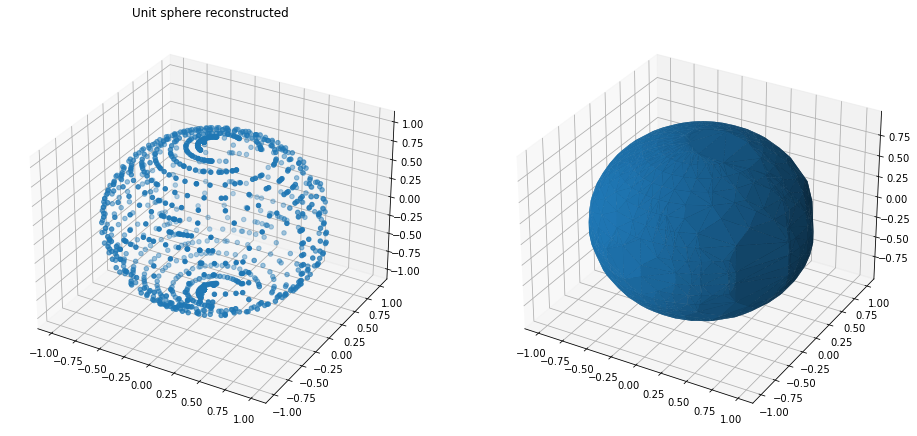

In [16]:
(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)
mesh_recons = tri.convex.convex_hull(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T)

fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(121, projection='3d')
ax1.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax1.set_title("Unit sphere reconstructed")

ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(mesh_recons.vertices[:, 0], mesh_recons.vertices[:,1], triangles=mesh_recons.faces, Z=mesh_recons.vertices[:,2])
plt.show()

Imprecision on the borders of $[0, \pi] \times [0, 2 \pi]$ !!!

# Brownian motion on the basis

In [17]:
def my_sphere_function_r(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

N = 64
sphere = tri.creation.uv_sphere(count=[N, N])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

In [18]:
n = 50
my_basis = SphHarmBasis(n_coeffs=n)

my_coeffs_r = my_basis.sph_harm_transform(my_sphere_function_r)
my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)

my_reconstr_function_r = my_basis.sph_harm_reconstruct(my_coeffs_r)
my_reconstr_function_theta = my_basis.sph_harm_reconstruct(my_coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(my_coeffs_phi)

f_recons_r = my_reconstr_function_r(theta,phi)
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)

Q = np.eye(N)
my_reconstr_stoch_r = my_basis.sph_harm_reconstruct_random(my_coeffs_r, Q, 0.0002)
my_reconstr_stoch_theta = my_basis.sph_harm_reconstruct_random(my_coeffs_theta, Q, 0.0002)
my_reconstr_stoch_phi = my_basis.sph_harm_reconstruct_random(my_coeffs_phi, Q, 0.0002)

f_stoch_r = my_reconstr_stoch_r(theta,phi)
f_stoch_theta = my_reconstr_stoch_theta(theta,phi)
f_stoch_phi = my_reconstr_stoch_phi(theta,phi)

In [19]:
(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(f_actual_r, f_actual_theta, f_actual_phi)
mesh = tri.convex.convex_hull(np.array([x_coord, y_coord, z_coord]).T)
(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)
mesh_recons = tri.convex.convex_hull(np.array([x_coord_recons, y_coord_recons, z_coord_recons]).T)

(x_coord_stoch, y_coord_stoch, z_coord_stoch) = pyssht.spherical_to_cart(f_stoch_r, f_stoch_theta, f_stoch_phi)
mesh_stoch = tri.convex.convex_hull(np.array([x_coord_stoch, y_coord_stoch, z_coord_stoch]).T)

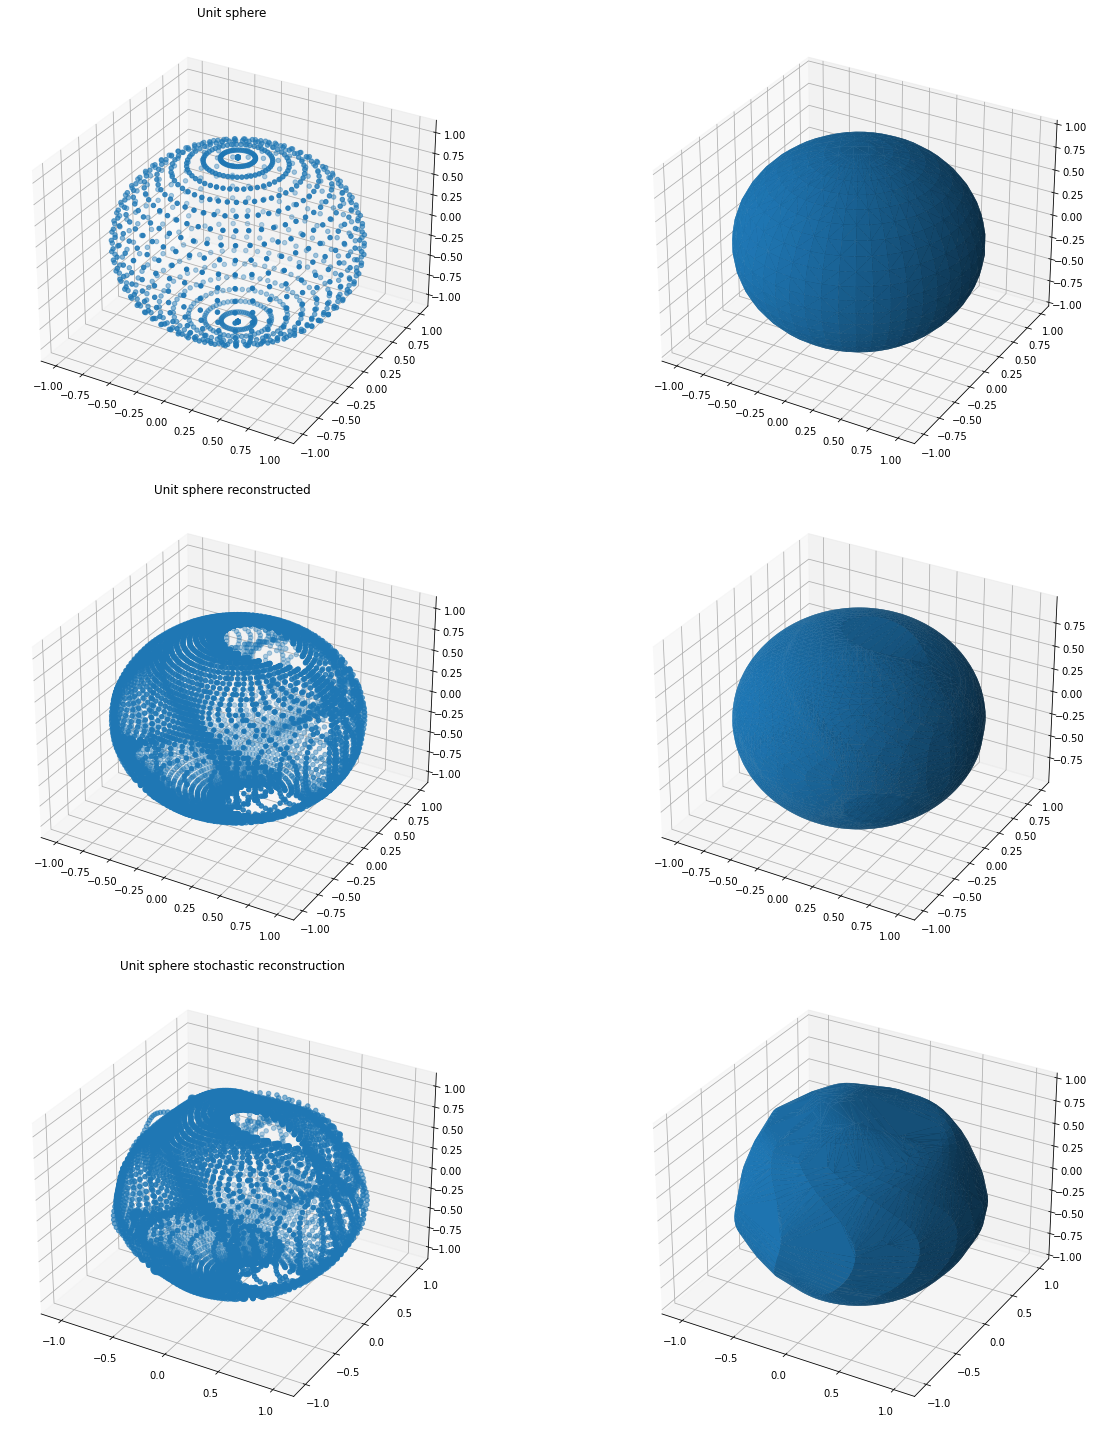

In [20]:
fig = plt.figure(figsize=(20,20))
ax1 = fig.add_subplot(321, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")

ax2 = fig.add_subplot(322, projection='3d')
ax2.plot_trisurf(mesh.vertices[:, 0], mesh.vertices[:,1], triangles=mesh.faces, Z=mesh.vertices[:,2])

ax3 = fig.add_subplot(323, projection='3d')
ax3.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax3.set_title("Unit sphere reconstructed")

ax4 = fig.add_subplot(324, projection='3d')
ax4.plot_trisurf(mesh_recons.vertices[:, 0], mesh_recons.vertices[:,1], triangles=mesh_recons.faces, Z=mesh_recons.vertices[:,2])

ax5 = fig.add_subplot(325, projection='3d')
ax5.scatter(x_coord_stoch, y_coord_stoch, z_coord_stoch)
ax5.set_title("Unit sphere stochastic reconstruction")

ax6 = fig.add_subplot(326, projection='3d')
ax6.plot_trisurf(mesh_stoch.vertices[:, 0], mesh_stoch.vertices[:,1], triangles=mesh_stoch.faces, Z=mesh_stoch.vertices[:,2])

plt.tight_layout()
plt.show()

### Sequence

In [250]:
N = 64
n = 50
sphere = tri.creation.uv_sphere(count=[N, N])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)
my_basis = SphHarmBasis(n_coeffs=n)

timestamp = np.linspace(0,0.01, 50)
listpq = []

def my_sphere_function_r(theta, phi):
    return np.array([1.0 for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return theta

def my_sphere_function_phi(theta, phi):
    return phi

In [251]:
x = np.linspace(0, np.max((n,N)), np.max((n,N)))
lambdas = np.where(abs(x)<=5, 1, 0)
Q = np.diag(lambdas) #covariance operator
Q = np.eye(np.max((n,N)))

In [252]:
for t in timestamp:
    
    my_coeffs_r = my_basis.sph_harm_transform(my_sphere_function_r)
    my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
    my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)
    
    my_reconstr_stoch_r = my_basis.sph_harm_reconstruct_random(my_coeffs_r, Q, t)
    my_reconstr_stoch_theta = my_basis.sph_harm_reconstruct_random(my_coeffs_theta, Q, t)
    my_reconstr_stoch_phi = my_basis.sph_harm_reconstruct_random(my_coeffs_phi, Q, t)

    f_stoch_r = my_reconstr_stoch_r(theta,phi)
    f_stoch_theta = my_reconstr_stoch_theta(theta,phi)
    f_stoch_phi = my_reconstr_stoch_phi(theta,phi)
    
    (x_coord_stoch, y_coord_stoch, z_coord_stoch) = pyssht.spherical_to_cart(f_stoch_r, f_stoch_theta, f_stoch_phi)
    listpq.append([x_coord_stoch, y_coord_stoch, z_coord_stoch])
        
listpq = np.array(listpq)

KeyboardInterrupt: 

In [253]:
rows_unique = np.unique(listpq[0,:,:].T, axis=0, return_index=True)
new = listpq[0,:,:].T[rows_unique[1]]
hull = tri.convex.convex_hull(new, qhull_options='QbB Pp Qt QJ')
faces = hull.faces

TypeError: list indices must be integers or slices, not tuple

In [254]:
listpq[0,:,:].T[rows_unique[1]][:,0]

array([-0.99970843, -0.99970843, -0.99853058, ...,  0.99815722,
        0.99815722,  0.99815722])

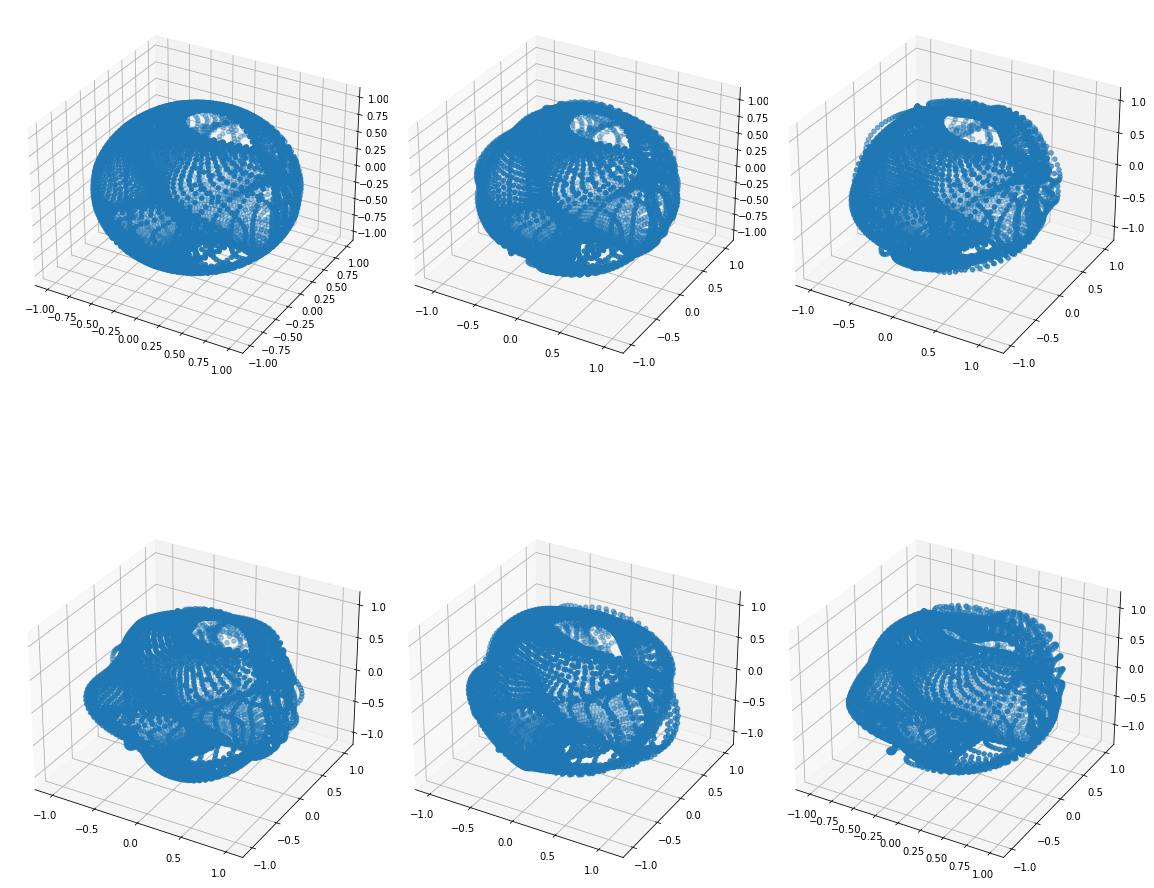

In [255]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.scatter(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.scatter(listpq[1,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.scatter(listpq[2,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.scatter(listpq[3,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.scatter(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.scatter(listpq[5,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

In [256]:
steps = []
for i in range(timestamp.size):
    steps.append(listpq[i,:,:].T[rows_unique[1]])
steps = np.array(steps)

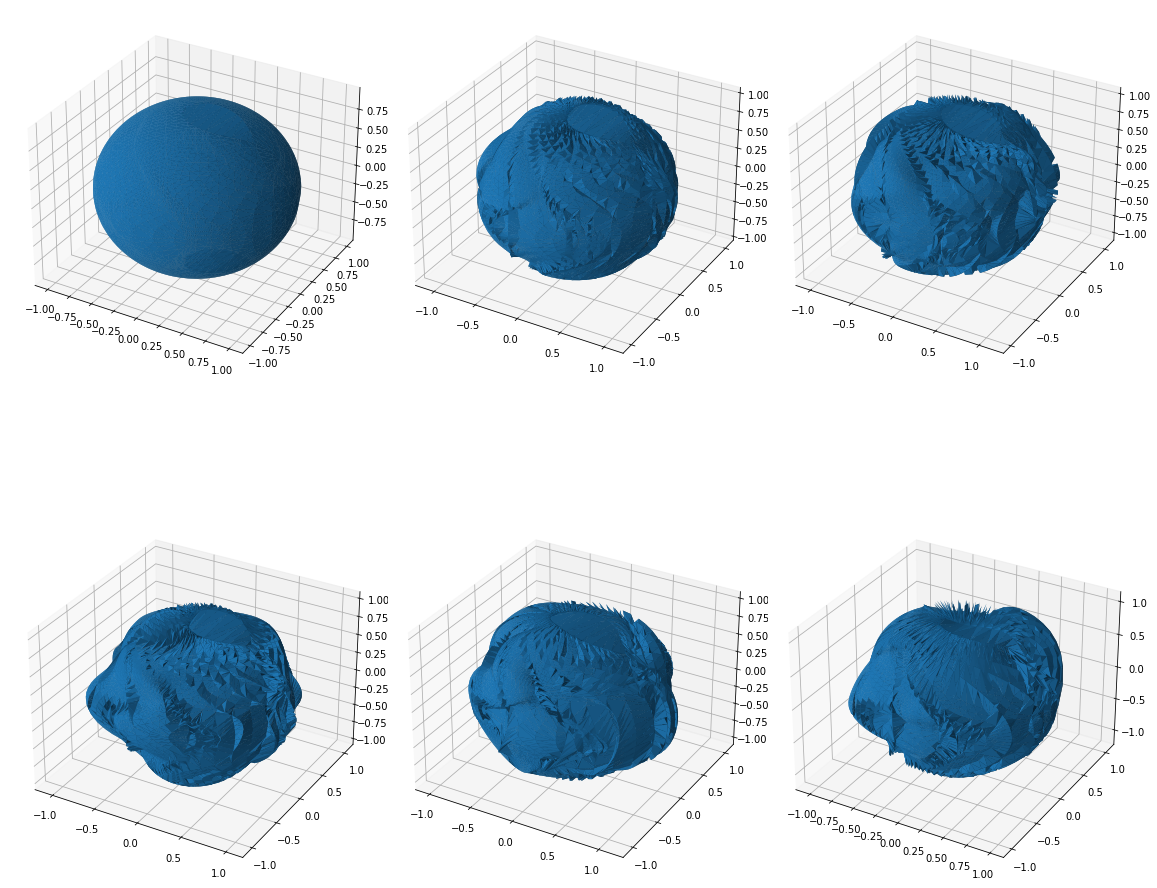

In [257]:
fig = plt.figure(figsize=(16,16))

ax1 = fig.add_subplot(231, projection='3d')
ax1.plot_trisurf(listpq[0,:,:].T[rows_unique[1]][:,0], listpq[0,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[0,:,:].T[rows_unique[1]][:,2])

ax2 = fig.add_subplot(232, projection='3d')
ax2.plot_trisurf(listpq[1,:,:].T[rows_unique[1]][:,0], listpq[1,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[1,:,:].T[rows_unique[1]][:,2])

ax3 = fig.add_subplot(233, projection='3d')
ax3.plot_trisurf(listpq[2,:,:].T[rows_unique[1]][:,0], listpq[2,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[2,:,:].T[rows_unique[1]][:,2])

ax4 = fig.add_subplot(234, projection='3d')
ax4.plot_trisurf(listpq[3,:,:].T[rows_unique[1]][:,0], listpq[3,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[3,:,:].T[rows_unique[1]][:,2])

ax5 = fig.add_subplot(235, projection='3d')
ax5.plot_trisurf(listpq[4,:,:].T[rows_unique[1]][:,0], listpq[4,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[4,:,:].T[rows_unique[1]][:,2])

ax6 = fig.add_subplot(236, projection='3d')
ax6.plot_trisurf(listpq[5,:,:].T[rows_unique[1]][:,0], listpq[5,:,:].T[rows_unique[1]][:,1], triangles=faces, Z=listpq[5,:,:].T[rows_unique[1]][:,2])

plt.tight_layout()
plt.show()

## Stochastic deformation of the sphere animation

In [258]:
import imageio
from matplotlib.collections import PolyCollection

In [259]:
filenames = []
for i in range(len(listpq)):

    def frustum(left, right, bottom, top, znear, zfar):
        M = np.zeros((4, 4), dtype=np.float32)
        M[0, 0] = +2.0 * znear / (right - left)
        M[1, 1] = +2.0 * znear / (top - bottom)
        M[2, 2] = -(zfar + znear) / (zfar - znear)
        M[0, 2] = (right + left) / (right - left)
        M[2, 1] = (top + bottom) / (top - bottom)
        M[2, 3] = -2.0 * znear * zfar / (zfar - znear)
        M[3, 2] = -1.0
        return M
    def perspective(fovy, aspect, znear, zfar):
        h = np.tan(0.5*np.radians(fovy)) * znear
        w = h * aspect
        return frustum(-w, w, -h, h, znear, zfar)
    def translate(x, y, z):
        return np.array([[1, 0, 0, x], [0, 1, 0, y],
                         [0, 0, 1, z], [0, 0, 0, 1]], dtype=float)
    def xrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return np.array([[1, 0,  0, 0], [0, c, -s, 0],
                         [0, s,  c, 0], [0, 0,  0, 1]], dtype=float)
    def yrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return  np.array([[ c, 0, s, 0], [ 0, 1, 0, 0],
                          [-s, 0, c, 0], [ 0, 0, 0, 1]], dtype=float)

    def zrotate(theta):
        t = np.pi * theta / 180
        c, s = np.cos(t), np.sin(t)
        return  np.array([[ c, -s, 0, 0], [ s, c, 0, 0],
                          [0, 0, 1, 0], [ 0, 0, 0, 1]], dtype=float)

    V = np.array(steps[i])
    #V = np.array([it[:,0], it[:,1], it[:,2]]).T
    F = np.array([faces[:,0], faces[:,1], faces[:,2]]).T

    V = (V-(V.max(0)+V.min(0))/2) / max(V.max(0)-V.min(0))
    MVP = perspective(25,1,1,100) @ translate(0,0,-3.5) @ xrotate(120) @ yrotate(180) @ zrotate(-20)
    V = np.c_[V, np.ones(len(V))]  @ MVP.T
    V /= V[:,3].reshape(-1,1)
    V = V[F]
    T =  V[:,:,:2]
    Z = -V[:,:,2].mean(axis=1)
    zmin, zmax = Z.min(), Z.max()
    Z = (Z-zmin)/(zmax-zmin)
    C = plt.get_cmap("magma")(Z)
    I = np.argsort(Z)
    T, C = T[I,:], C[I,:]
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_axes([0,0,1,1], xlim=[-1,+1], ylim=[-1,+1], aspect=1, frameon=False)
    collection = PolyCollection(T, closed=True, linewidth=0.1, facecolor=C, edgecolor="black")
    ax.add_collection(collection)
    
    # create file name and append it to a list
    filename = f'{i}.png'
    filenames.append(filename)
    
    # last frame of each viz stays longer
    if (i == len(listpq)-1):
            for i in range(5):
                filenames.append(filename)
    
    # save frame
    plt.savefig(filename)
    plt.close()# build gif
    
with imageio.get_writer('test.gif', mode='I') as writer:
    for filename in filenames:
        image = imageio.imread(filename)
        writer.append_data(image)
        
# Remove files
for filename in set(filenames):
    os.remove(filename)

/tmp/ipykernel_170/2897345904.py:74: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning dissapear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


# Complex shape

In [25]:
from utils import lddmm_utils, mesh_processing
import open3d as o3d
sys.path.insert(0,"../")

<stdin>:1:10: fatal error: 'omp.h' file not found
#include <omp.h>
         ^~~~~~~
1 error generated.


[KeOps] Warning : omp.h header is not in the path, disabling OpenMP.
[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


In [26]:
def get_data(file):
    mesh = o3d.io.read_triangle_mesh(file)
    V, F, Rho = mesh_processing.getDataFromMesh(mesh)
    return(V,F,Rho)

V,F,Rho = get_data("../data/test_data/bunny.ply")

mesh = tri.Trimesh(V,F)

In [27]:
mesh.vertices.shape

(34834, 3)

In [35]:
shape_x, shape_y, shape_z = np.array(mesh.vertices[:,0]), np.array(mesh.vertices[:,1]), np.array(mesh.vertices[:,2])
(shape_r, shape_theta, shape_phi) = pyssht.cart_to_spherical(shape_x, shape_y, shape_z)

def my_sphere_function_r(theta, phi):
    return np.array([shape_r[t] for t in range(np.array(theta).size)])

def my_sphere_function_theta(theta, phi):
    return np.array([shape_theta[t] for t in range(np.array(theta).size)])

def my_sphere_function_phi(theta, phi):
    return np.array([shape_phi[t] for t in range(np.array(theta).size)])

sphere = tri.creation.uv_sphere(count=[128, 128])
x, y ,z = np.array(sphere.vertices[:,0]), np.array(sphere.vertices[:,1]), np.array(sphere.vertices[:,2])
(r, theta, phi) = pyssht.cart_to_spherical(x, y, z)

In [36]:
import pyshtools as pysh
import numpy as np

lat = np.linspace(0, np.pi, mesh.vertices.shape[0])
lon = np.linspace(0, 2*np.pi, mesh.vertices.shape[0])
lmax = 50

theta_coeffs = pysh.expand.SHExpandLSQ(d=shape_theta, lat=lat, lon=lon, lmax=lmax)
phi_coeffs = pysh.expand.SHExpandLSQ(d=shape_phi, lat=lat, lon=lon, lmax=lmax)
r_coeffs = pysh.expand.SHExpandLSQ(d=shape_r, lat=lat, lon=lon, lmax=lmax)

In [37]:
x_recon = pysh.expand.MakeGridPoint(theta_coeffs[0], lat=lat, lon=lon)
y_recon = pysh.expand.MakeGridPoint(phi_coeffs[0], lat=lat, lon=lon)
z_recon = pysh.expand.MakeGridPoint(r_coeffs[0], lat=lat, lon=lon)

print(x_recon)

[1.578125  1.8125    1.3046875 ... 1.8046875 2.21875   2.296875 ]


In [38]:
(x, y, z) = pyssht.spherical_to_cart(x_recon, y_recon, z_recon)

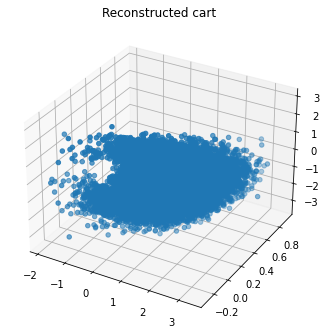

In [39]:
def plot_coords(x_coords: np.array, y_coords: np.array, z_coords: np.array, title: str = "Coords"):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(121, projection='3d')
    ax.scatter(x_coords, y_coords, z_coords)
    ax.set_title(title)
    plt.show()

plot_coords(x, y, z, title="Reconstructed cart")

In [ ]:
my_basis = SphHarmBasis(n_coeffs=20)

f_actual_r = my_sphere_function_r(theta,phi)
f_actual_theta = my_sphere_function_theta(theta,phi)
f_actual_phi = my_sphere_function_phi(theta,phi)

my_coeffs_r = my_basis.sph_harm_transform(my_sphere_function_r)
my_coeffs_theta = my_basis.sph_harm_transform(my_sphere_function_theta)
my_coeffs_phi = my_basis.sph_harm_transform(my_sphere_function_phi)

my_reconstr_function_r = my_basis.sph_harm_reconstruct(my_coeffs_r)
my_reconstr_function_theta = my_basis.sph_harm_reconstruct(my_coeffs_theta)
my_reconstr_function_phi = my_basis.sph_harm_reconstruct(my_coeffs_phi)

f_recons_r = my_reconstr_function_r(theta,phi)
f_recons_theta = my_reconstr_function_theta(theta,phi)
f_recons_phi = my_reconstr_function_phi(theta,phi)

my_reconstr_stoch_r = my_basis.sph_harm_reconstruct_random(my_coeffs_r, 0.0002)
my_reconstr_stoch_theta = my_basis.sph_harm_reconstruct_random(my_coeffs_theta, 0.0002)
my_reconstr_stoch_phi = my_basis.sph_harm_reconstruct_random(my_coeffs_phi, 0.0002)

f_stoch_r = my_reconstr_stoch_r(theta,phi)
f_stoch_theta = my_reconstr_stoch_theta(theta,phi)
f_stoch_phi = my_reconstr_stoch_phi(theta,phi)

In [ ]:
(x_coord, y_coord, z_coord) = pyssht.spherical_to_cart(f_actual_r, f_actual_theta, f_actual_phi)

(x_coord_recons, y_coord_recons, z_coord_recons) = pyssht.spherical_to_cart(f_recons_r, f_recons_theta, f_recons_phi)

(x_coord_stoch, y_coord_stoch, z_coord_stoch) = pyssht.spherical_to_cart(f_stoch_r, f_stoch_theta, f_stoch_phi)

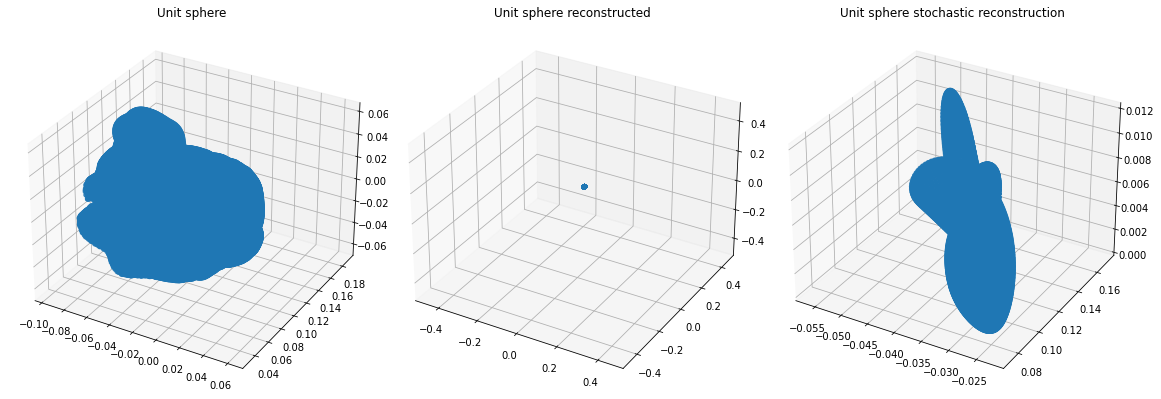

In [ ]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(x_coord, y_coord, z_coord)
ax1.set_title("Unit sphere")

ax3 = fig.add_subplot(132, projection='3d')
ax3.scatter(x_coord_recons, y_coord_recons, z_coord_recons)
ax3.set_title("Unit sphere reconstructed")

ax5 = fig.add_subplot(133, projection='3d')
ax5.scatter(x_coord_stoch, y_coord_stoch, z_coord_stoch)
ax5.set_title("Unit sphere stochastic reconstruction")

plt.tight_layout()
plt.show()

In [ ]:
y_coord_recons

array([0.12794, 0.12794, 0.12794, ..., 0.12794, 0.12794, 0.12794])

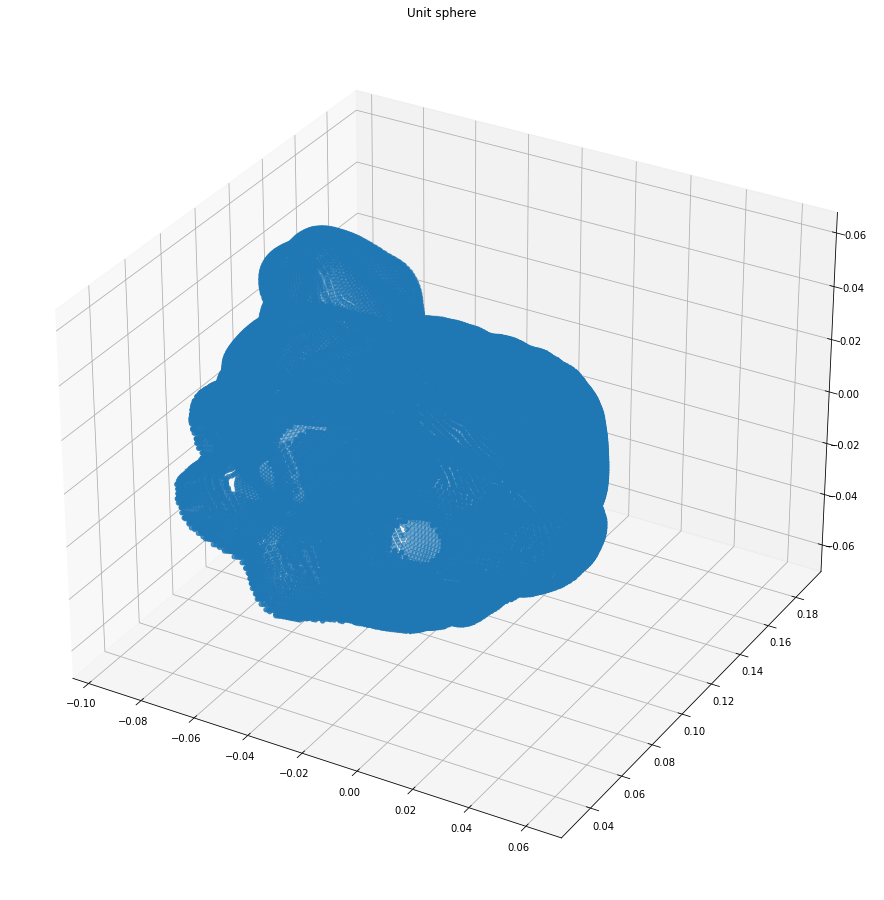

In [ ]:
fig = plt.figure(figsize=(16,16))
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(np.array(mesh.vertices[:,0]), np.array(mesh.vertices[:,1]), np.array(mesh.vertices[:,2]))
ax1.set_title("Unit sphere")

plt.show()